In [15]:
from __future__ import print_function
import torch

In [16]:
torch.cuda.device_count()

0

In [3]:
# construct a matrix of 5*3
x = torch.Tensor(5,3)
# initial a random matrix
x = torch.rand(5,3)
x.size()

torch.Size([5, 3])

In [4]:
# initial a random matrix for y
y = torch.rand(5,3)

In [5]:
# add two matrix
x+y #method 1
torch.add(x,y) #method 2

tensor([[0.9579, 0.9046, 1.8345],
        [0.7632, 0.5831, 0.6890],
        [1.1433, 0.1436, 0.3291],
        [1.2358, 1.5951, 1.4674],
        [0.4222, 1.1447, 0.8552]])

In [7]:
# output tensor
result = torch.Tensor(5,3) # method 1
torch.add(x,y,out = result) # method 2
y.add_(x)
# 特别注明：任何可以改变tensor内容的操作都会在方法名后加一个下划线'_'
# 例如：x.copy_(y), x.t_(), 这俩都会改变x的值。

tensor([[1.2341, 1.6478, 2.8310],
        [1.4369, 0.9034, 1.0978],
        [1.6969, 0.2393, 0.4835],
        [1.5046, 2.3512, 2.3790],
        [0.5833, 1.7902, 1.5585]])

# Numpy bridge

In [8]:
a = torch.ones(5)
b = a.numpy()
print('a:',a)
print('b:',b)

a: tensor([1., 1., 1., 1., 1.])
b: [1. 1. 1. 1. 1.]


In [9]:
# 此处演示当修改numpy数组之后,与之相关联的tensor也会相应的被修改
a.add_(1)
print(a)
print(b)

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


In [11]:
# transfer Array of numpy to Tensor of torch
import numpy as np
x = np.ones(5)
y = torch.from_numpy(x)
np.add(x,1,out = x)
print(x)
print(y)
type(x)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


numpy.ndarray

In [13]:
# 另外除了CharTensor之外，所有的tensor都可以在CPU运算和GPU预算之间相互转换
# 使用CUDA函数来将Tensor移动到GPU上
# 当CUDA可用时会进行GPU的运算
if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x + y



# PyTorch中所有的神经网络都来自于autograd包
这是一个运行时定义的框架，这意味着你的反向传播是根据你代码运行的方式来定义的，因此每一轮迭代都可以各不相同。
autograd.Variable 这是这个包中最核心的类。 它包装了一个Tensor，并且几乎支持所有的定义在其上的操作。一旦完成了你的运算，你可以调用 .backward()来自动计算出所有的梯度。
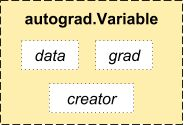
Variable 和 Function 二者相互联系并且构建了一个描述整个运算过程的无环图。每个Variable拥有一个 .grad_fn 属性，其引用了一个创建Variable的 Function。(除了用户创建的Variable其 grad_fn 部分是 None)。
如果你想要进行求导计算，你可以在Variable上调用.backward()。 如果Variable是一个标量（例如它包含一个单元素数据），你无需对backward()指定任何参数，如果它有更多的元素，你需要指定一个和tensor的形状想匹配的grad_output参数。

In [35]:
from torch.autograd import Variable

In [46]:
x = Variable(torch.ones(2,2),requires_grad = True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [47]:
y = x+2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [48]:
y.grad_fn

In [51]:
z = y*y*3
z

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)

In [52]:
out = z.mean()
out

tensor(27., grad_fn=<MeanBackward0>)

In [54]:
out.backward()

In [55]:
x.grad

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

In [56]:
# other crazy staff

In [57]:
x = torch.randn(3)
x = Variable(x, requires_grad = True)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)
x.grad

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)